In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, NumbaPerformanceWarning
import cv2

from plot_helpers import plotCoordinateFrame, set_axes_equal
from jacobian import jac
from manifold import K_from_vec, vec_from_K, SE3_from_vec, vec_from_SE3, skew
from optimize import levenberg_marquardt

import warnings
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)
np.set_printoptions(suppress=True, precision=3, edgeitems=30, linewidth=100000)

In [2]:
#----------- Projection helpers ----------#
@njit
def h(K, T, P):
    p_homo = K@T@to_homogen(P).T
    return from_homogen(p_homo.T)

@njit
def to_homogen(p):
    return np.hstack(( p, np.ones((p.shape[0], 1)) ))

@njit
def from_homogen(p):
    p /= p[:,-1:]
    return p[:,:-1]

@njit
def residuals(K, Ts, Ps, zs):     
    # Compute expected measurements
    l = zs[0].size
    res = np.zeros(l * Ts.shape[0])
    for i, T in enumerate(Ts):
        p_prime = h(K, T, Ps)
        res[i*l:(i+1)*l] = (zs[i] - p_prime).flatten()
    
    return res

### Load ground truth data

In [24]:
gt = np.loadtxt("templeRing/templeR_par.txt", skiprows=1, usecols=range(1,1+9+9+3))
# only do the first 2 pictures first
img_indices = [0,1]
gt = gt[img_indices]
M = gt.shape[0]

K_gt = gt[0,:9].reshape((3,3))

# Rotate so z points at object instead of away from
flip_z = np.array([[-1, 0, 0, 0],
                   [0, 1, 0, 0],
                   [0, 0, -1, 0],
                   [0, 0, 0, 1]]) 
Ts_gt = np.zeros((M, 4, 4))
for i in range(M):
    Ts_gt[i,:3,:3] = gt[i,9:18].reshape((3,3))
    Ts_gt[i,:3,3] = gt[i,18:]
    Ts_gt[i,3,3] = 1
    Ts_gt[i] = Ts_gt[i]@flip_z
    
    
# Make first pose the identity
offset = np.linalg.inv(Ts_gt[0])
for i in range(1,M):
    Ts_gt[i] = offset@Ts_gt[i]
Ts_gt[0] = np.eye(4)

### Apply noise to intrinsics/pose ground truth

In [25]:
K_init = K_from_vec( vec_from_K(K_gt) + np.random.normal(scale=50, size=4) )

### Match points

In [26]:
def find_kp(im):
    # find the keypoints and descriptors with SIFT
    kp, des = sift.detectAndCompute(im,None)
    kp = np.array([k.pt for k in kp])
    return kp, des

# There was a bunch of bugs in the original implementation...
def plotMatches(im1, im2, locs1, locs2, filename=None):
    fig = plt.figure()
    # draw two images side by side
    imH = max(im1.shape[0], im2.shape[0])
    im = np.zeros((imH, im1.shape[1]+im2.shape[1]), dtype='uint8')
    
    if len(im1.shape) >= 3:
        im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    if len(im2.shape) >= 3:
        im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
        
    im[0:im1.shape[0], 0:im1.shape[1]] = im1
    im[0:im2.shape[0], im1.shape[1]:] = im2
    
    plt.imshow(im, cmap='gray')
    for ((x1, y1), (x2, y2)) in zip(locs1, locs2):
        plt.plot([x1, x2+im1.shape[1]], [y1,y2], 'r', lw=0.5)

    plt.show()
    
def sevenpoint(pts1, pts2, M):
    '''
    Q1.2: Seven Point Algorithm for calculating the fundamental matrix
        Input:  pts1, 7x2 Matrix containing the corresponding points from image1
                pts2, 7x2 Matrix containing the corresponding points from image2
                M, a scalar parameter computed as max (imwidth, imheight)
        Output: Farray, a list of estimated 3x3 fundamental matrixes.
    '''
    Farray = []

    # Computing the 3x3 matrix used to normalize corresponding points. 
    T = np.diag([1/M,1/M,1])
    
    # Scale our points
    pts1 = pts1@T[:2,:2]
    pts2 = pts2@T[:2,:2]
    x1, y1 = pts1.T
    x2, y2 = pts2.T
    ones = np.ones_like(x2)
    
    # Create our matrices
    A = np.column_stack((x1*x2, x1*y2, x1, y1*x2, y1*y2, y1, x2, y2, ones))
    
    # Use SVD to extract F
    U, S, VT = np.linalg.svd(A)
    Fs = np.array([VT[-1].reshape((3,3)).T, VT[-2].reshape((3,3)).T])
    
    # Solve cubic
    D = np.zeros((2,2,2))
    for i1 in range(2):
        for i2 in range(2):
            for i3 in range(2):
                temp = np.zeros((3,3))
                temp[:,0] = Fs[i1,0]
                temp[:,1] = Fs[i2,1]
                temp[:,2] = Fs[i3,2]
                D[i1,i2,i3] = np.linalg.det(temp)
                
    coeff = np.zeros(4)
    coeff[0] = -D[1][0][0]+D[0][1][1]+D[0][0][0]+D[1][1][0]+D[1][0][1]-D[0][1][0]-D[0][0][1]-D[1][1][1];
    coeff[1] = D[0][0][1]-2*D[0][1][1]-2*D[1][0][1]+D[1][0][0]-2*D[1][1][0]+D[0][1][0]+3*D[1][1][1];
    coeff[2] = D[1][1][0]+D[0][1][1]+D[1][0][1]-3*D[1][1][1];
    coeff[3] = D[1][1][1];

    roots = np.polynomial.polynomial.polyroots(coeff[::-1])
    for r in roots:
        if np.isreal(r):
            a = np.real(r)
            F = Fs[0]*a + (1-a)*Fs[1]
            # Clean up matrix
            F = T.T@F@T
            F = F/F[2,2]
            Farray.append( F )
    
    return Farray    

def calc_epi_error(pts1_homo, pts2_homo, F):
    '''
    Helper function to calculate the sum of squared distance between the corresponding points and the estimated epipolar lines. 
    Expect pts1 and pts2 are in homogeneous coordinates and not normalized. 
    '''
    line1s = pts1_homo.dot(F.T)
    dist1 = np.square(np.divide(np.sum(np.multiply(
        line1s, pts2_homo), axis=1), np.linalg.norm(line1s[:, :2], axis=1)))

    line2s = pts2_homo.dot(F)
    dist2 = np.square(np.divide(np.sum(np.multiply(
        line2s, pts1_homo), axis=1), np.linalg.norm(line2s[:, :2], axis=1)))

    ress = (dist1 + dist2).flatten()
    return ress

def ransacF(pts1, pts2, M, max_iter=1000, tol=2):
    '''
    Q3.1: RANSAC method.
        Input:  pts1, Nx2 Matrix
                pts2, Nx2 Matrix
                M, a scaler parameter
        Output: F, the fundamental matrix
                inlier_curr, Nx1 bool vector set to true for inliers
    '''
    N = pts1.shape[0]
    pts1_homo, pts2_homo = to_homogen(pts1), to_homogen(pts2)
    inlier_curr = np.zeros(pts1.shape[0])
    
    # ----- TODO -----
    for i in range(max_iter):
        # Find H from random sample
        idx = np.random.randint(0, N, 7)
        Fs = sevenpoint(pts1[idx], pts2[idx], M)
        
        for F_prop in Fs:
            err = calc_epi_error(pts1_homo, pts2_homo, F_prop)
            inl = err < tol
            if np.sum(inl) > np.sum(inlier_curr):
                inlier_curr = inl
                F = F_prop
                
    return F, inlier_curr

def poses_from_FK(F, K):
    # First find the essential matrix
    E = K.T@F@K
    
    # Enforce rank 2
    # Not needed as it doesn't impact later results
    # U,S,V = np.linalg.svd(E)
    # m = S[:2].mean()
    # E = U.dot(np.array([[m,0,0], [0,m,0], [0,0,0]])).dot(V)
    
    # Decompose to find pose options
    U,S,V = np.linalg.svd(E)
    W = np.array([[0,-1,0], [1,0,0], [0,0,1]])

    # Make sure we have the right size
    if np.linalg.det(U.dot(W).dot(V))<0:
        W = -W

    # Make all possible options
    M2s = np.zeros([3,4,4])
    M2s[:,:,0] = np.concatenate([U.dot(W).dot(V), U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
    M2s[:,:,1] = np.concatenate([U.dot(W).dot(V), -U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
    M2s[:,:,2] = np.concatenate([U.dot(W.T).dot(V), U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
    M2s[:,:,3] = np.concatenate([U.dot(W.T).dot(V), -U[:,2].reshape([-1, 1])/abs(U[:,2]).max()], axis=1)
    return M2s

def triangulate(C1, pts1, C2, pts2):
    '''
    Q2.2: Triangulate a set of 2D coordinates in the image to a set of 3D points.
        Input:  C1, the 3x4 camera matrix
                pts1, the Nx2 matrix with the 2D image coordinates per row
                C2, the 3x4 camera matrix
                pts2, the Nx2 matrix with the 2D image coordinates per row
        Output: P, the Nx3 matrix with the corresponding 3D points per row
                err, the reprojection error.
    
    ***
    Hints:
    (1) For every input point, form A using the corresponding points from pts1 & pts2 and C1 & C2
    (2) Solve for the least square solution using np.linalg.svd
    (3) Calculate the reprojection error using the calculated 3D points and C1 & C2 (do not forget to convert from 
        homogeneous coordinates to non-homogeneous ones)
    (4) Keep track of the 3D points and projection error, and continue to next point 
    (5) You do not need to follow the exact procedure above. 
    '''
    # ----- TODO -----
    p11, p12, p13 = C1
    p21, p22, p23 = C2
    N = pts1.shape[0]
    
    err = 0
    Pest = np.zeros((N,3))
    for i, ((x1, y1), (x2,y2)) in enumerate(zip(pts1, pts2)):
        # Get homogenous point
        A = np.vstack((
                        y1*p13 -    p12, 
                           p11 - x1*p13,
                        y2*p23 -    p22,
                           p21 - x2*p23
                ))
        
        U, S, VT = np.linalg.svd(A)
        Pi = VT[-1]
        Pi /= Pi[-1]
        
        # Compute reprojection err
        reproj_1 = C1@Pi
        reproj_2 = C2@Pi
        reproj_1 /= reproj_1[-1]
        reproj_2 /= reproj_2[-1]

        err += np.sum( (reproj_1[:2] - [x1,y1])**2 ) + np.sum( (reproj_2[:2] - [x2,y2])**2 ) #+ np.linalg.norm(X)/10
        Pest[i] = Pi[:3]
        
    return Pest, err
    

def find_pose(F, pts1, pts2, K):
    '''
    Q2.2: Function to find the camera2's projective matrix given correspondences
        Input:  F, the pre-computed fundamental matrix
                pts1, the Nx2 matrix with the 2D image coordinates per row
                pts2, the Nx2 matrix with the 2D image coordinates per row
                intrinsics, the intrinsics of the cameras, load from the .npz file
        Output: [M2, C2, P] the computed M2 (3x4) camera projective matrix, C2 (3x4) K2 * M2, and the 3D points P (Nx3)
    '''

    M1 = np.hstack((np.identity(3), np.zeros(3)[:,np.newaxis]))
    C1 = K@M1
    M2s = poses_from_FK(F, K_gt)
    best_error = np.finfo('float').max
    
    # Find which M is best
    for i in range(M2s.shape[-1]):
        Mi = M2s[:,:,i]
        Ci = K@Mi
        Pi, err = triangulate(C1, pts1, Ci, pts2)
        
        if err < best_error and np.all(Pi[:,2] >= 0):
            best_error = err
            M2best = Mi
            C2best = Ci
            P_best = Pi
    
    print(f"Best Error {best_error}")
    return M2best, P_best

Best Error 87698.78371494991
[[ 1.    -0.026 -0.01  -0.032]
 [ 0.027  0.993  0.117 -1.   ]
 [ 0.007 -0.117  0.993  0.306]]
[[ 0.991  0.005 -0.133  0.006]
 [-0.005  1.    -0.001 -0.   ]
 [ 0.133  0.002  0.991  0.003]
 [ 0.     0.     0.     1.   ]]


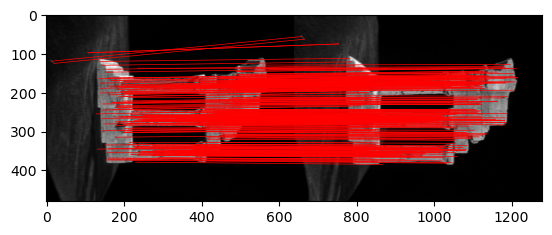

In [27]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

im1 = cv2.imread(f"templeRing/templeR000{img_indices[0]+1}.png")
im2 = cv2.imread(f"templeRing/templeR000{img_indices[1]+1}.png")

kp1, des1 = find_kp(im1)
kp2, des2 = find_kp(im2)

# BFMatcher with default params
bf = cv2.BFMatcher()
good_match = []
matches = bf.knnMatch(des1,des2,k=2)

# Ratio test
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good_match.append([m.queryIdx, m.trainIdx])
good_match = np.array(good_match)

# Estimate F and apply ransac
kp1 = kp1[good_match[:,0]]
kp2 = kp2[good_match[:,1]]
F, inlier = ransacF(kp1, kp2, np.max(im1.shape), max_iter=5000)
kp1 = kp1[inlier]
kp2 = kp2[inlier]

# Calculate Pose from fundamental matrix used for initialization
T1, Ps_init = find_pose(F, kp1, kp2, K_init[:3,:3])
Ts_init = Ts_gt.copy()
Ts_init[1,:3] = T1
print(T1)
print(Ts_gt[1])

# Put into array as measurements
zs = np.array([kp1, kp2])

plotMatches(im1, im2, kp1, kp2)

### Run Optimizer

In [28]:
%time K_result, Ts_result, Ps_result = levenberg_marquardt(residuals, K_init, Ts_init, Ps_init, zs, jac, max_iters=100, lam=.001, lam_multiplier=2, tol=1e-4, verbose=True)
np.linalg.norm(residuals(K_result, Ts_result, Ps_result, zs))

Starting cost: 87698.78371495003
0, 	 Cost: 763.1931945481131 	 Lam: 0.001
1, 	 Cost: 25.857893822752505 	 Lam: 0.001
2, 	 Cost: 15.739664936637741 	 Lam: 0.001
3, 	 Cost: 15.739447541955462 	 Lam: 0.001
4, 	 Cost: 15.739316639364684 	 Lam: 0.001
5, 	 Cost: 15.739192882874697 	 Lam: 0.001
6, 	 Cost: 15.73907578756998 	 Lam: 0.001
7, 	 Cost: 15.738965022013552 	 Lam: 0.001
8, 	 Cost: 15.738859966825444 	 Lam: 0.001
CPU times: user 139 ms, sys: 3.85 ms, total: 143 ms
Wall time: 139 ms


3.9672106591754903

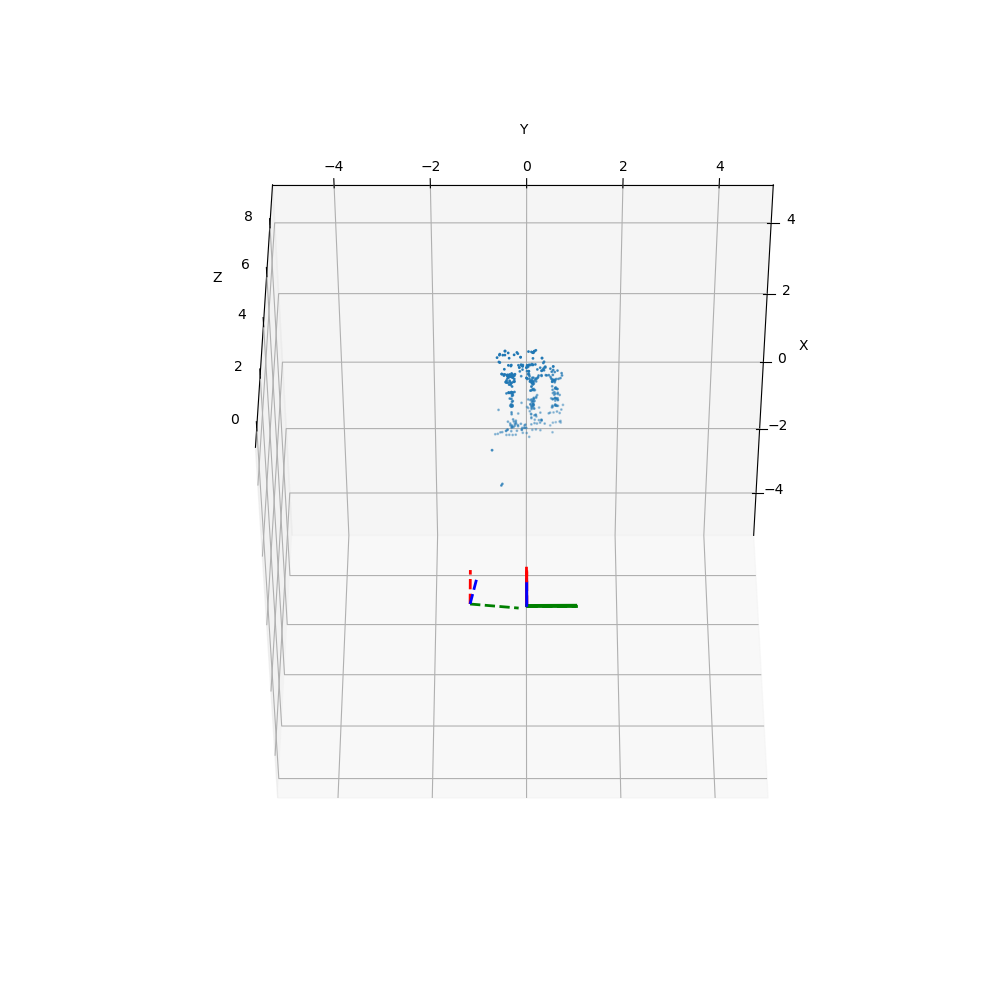

In [30]:
%matplotlib widget
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Ps_result[:,0], Ps_result[:,1], Ps_result[:,2], s=1)
for T, gt in zip(Ts_result, Ts_gt):
    plotCoordinateFrame(gt, ax=ax)
    plotCoordinateFrame(T, ax=ax, k="--")
set_axes_equal(ax)
ax.set_zlabel("Z")
ax.set_ylabel("Y")
ax.set_xlabel("X")
ax.view_init(-45, 0)
plt.show()